## Modelamiento Forecasting
by: Norma Giraldo

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import math
import dask
import dask.dataframe as dd
import multiprocessing as mtl
from scipy import stats
from sklearn.impute import KNNImputer
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from pmdarima import auto_arima # Para modelado SARIMAX
from prophet import Prophet
from dask.diagnostics import ProgressBar
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import tensorflow as tf # Para LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error # Métricas
from prophet.diagnostics import cross_validation, performance_metrics
import datetime
import pickle
# Para optimización bayesiana
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")

In [53]:
def cargar_y_preparar_datos(file_path):
    """
    Carga y prepara los datos con manejo adecuado de fechas
    """
    # Cargar el archivo con el formato de fecha correcto
    df = pd.read_csv(
        file_path, sep=';',             # Especificar el separador de columnas
        parse_dates=['Fecha'],          # Especificar la columna de fechas
        dayfirst=True                   # Indicar que el formato es DD-MM-YYYY
    )
    
    # Configurar la columna 'Fecha' como índice
    df.set_index('Fecha', inplace=True)
    df = df.asfreq('MS')
    
    # Para este análisis, nos enfocamos solo en SKU_25
    df_sku25 = df[['SKU_25']]
    
    return df_sku25

### Datos

In [54]:
# Path del archivo CSV
file_path = "C:/Users/norma/OneDrive/Tecnoquimicas TQ/prueba_tq/data/data_productos.csv"
df_sku25 = cargar_y_preparar_datos(file_path)
df_sku25.head()

,SKU_25
Fecha,
2018-01-01,22058
2018-02-01,23041
2018-03-01,24590
2018-04-01,30199
2018-05-01,26760


### Serie original

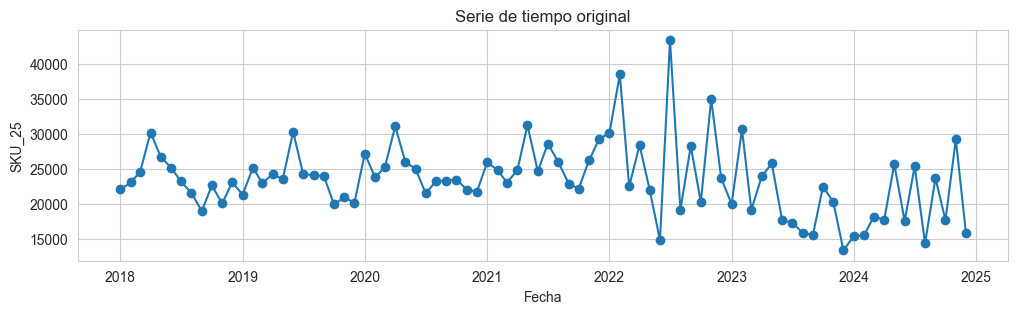

In [4]:
plt.figure(figsize=(12,3))
plt.plot(df_sku25.index, df_sku25['SKU_25'], marker='o')
plt.title('Serie de tiempo original')
plt.xlabel('Fecha')
plt.ylabel('SKU_25')
plt.show()

### Detección de outliers con STL

In [55]:
# Parámetro "period" se ajusta a 12 para datos mensuales con estacionalidad anual
stl = STL(df_sku25['SKU_25'], period=12, robust=True)
res = stl.fit()
residuals = res.resid

# Umbral de outliers: se puede usar un factor del std de los residuales
umbral_std = 3
std_res = np.std(residuals)
mean_res = np.mean(residuals)

outliers_idx = np.where((residuals < mean_res - umbral_std*std_res) | 
                        (residuals > mean_res + umbral_std*std_res))[0]

outliers = df_sku25.iloc[outliers_idx]
print("Posiciones de outliers detectados:")
print(outliers)

Posiciones de outliers detectados:
            SKU_25
Fecha             
2022-07-01   43420
2024-02-01   15517


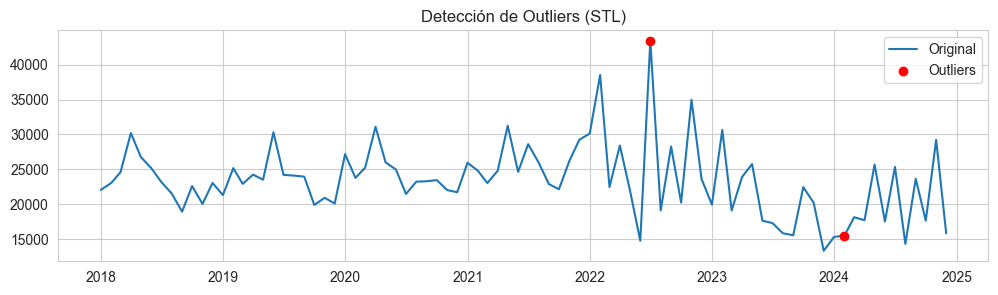

In [6]:
# Visualizamos
plt.figure(figsize=(12,3))
plt.plot(df_sku25.index, df_sku25['SKU_25'], label='Original')
plt.scatter(outliers.index, outliers['SKU_25'], color='red', label='Outliers', zorder=3)
plt.legend()
plt.title('Detección de Outliers (STL)')
plt.show()

### Imputación de outliers con knn

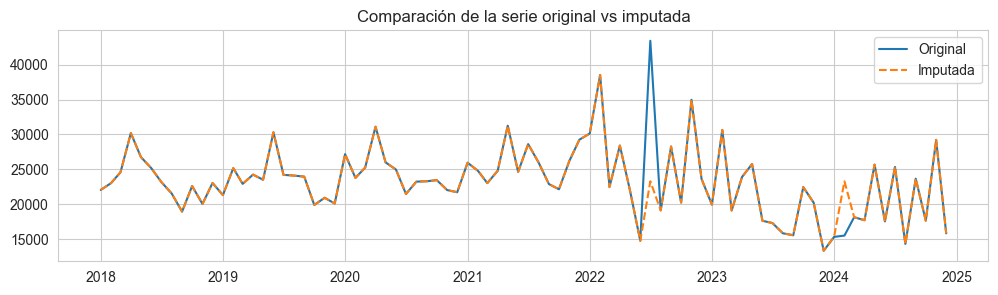

In [56]:
df_outlier = df_sku25.copy()
df_outlier.loc[outliers.index, 'SKU_25'] = np.nan  # Reemplazamos outliers por NaN

# KNNImputer necesita una matriz. Convertimos la serie en un DataFrame.
imputer = KNNImputer(n_neighbors=3)
imputed_values = imputer.fit_transform(df_outlier[['SKU_25']])
df_outlier['SKU_25'] = imputed_values

plt.figure(figsize=(12,3))
plt.plot(df_sku25.index, df_sku25['SKU_25'], label='Original')
plt.plot(df_outlier.index, df_outlier['SKU_25'], label='Imputada', linestyle='--')
plt.title('Comparación de la serie original vs imputada')
plt.legend()
plt.show()

# Actualizamos df para usar la versión imputada
df = df_outlier.copy()

In [8]:
result = adfuller(df['SKU_25'], autolag='AIC')
print("Estadístico ADF:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print('Critical Values:')
    print(f'   {key}, {value}')

Estadístico ADF: -3.8645050702128887
p-value: 0.002312167932789262
Critical Values:
   1%, -3.512738056978279
Critical Values:
   5%, -2.8974898650628984
Critical Values:
   10%, -2.585948732897085


### ljung_box_test

In [9]:
def ljung_box_test(ts, lags=12, alpha=0.05):
    """
    Applies the Ljung-Box test for autocorrelation to a time series.

    Args:
        ts (pd.Series or np.array): The time series data.
        lags (int or list, optional): The number of lags to test. Defaults to 12.
        alpha (float, optional): The significance level. Defaults to 0.05.

    Returns:
        pd.DataFrame: A DataFrame containing the Ljung-Box test results.
                      Includes the test statistic, p-value, and a boolean
                      indicating whether the null hypothesis (no autocorrelation)
                      is rejected.  Also returns the count of lags where 
                      the null hypothesis is not rejected.
    """

    if isinstance(lags, int):
        lags = list(range(1, lags + 1))  # Create a list of lags from 1 to lags

    ljungbox_results = pd.DataFrame()
    for lag in lags:
        lb_result = acorr_ljungbox(ts, lags=[lag], return_df=True)
        ljungbox_results = pd.concat([ljungbox_results, lb_result], axis=0)

    ljungbox_results['Reject H0'] = ljungbox_results['lb_pvalue'] < alpha  # Corrected comparison
    independent_residuals_count = ljungbox_results['Reject H0'].sum() #Count of rejects H0

    return ljungbox_results, independent_residuals_count

In [10]:
np.random.seed(0)
ts = df.copy()

ljungbox_df, independent_residuals_count = acorr_ljungbox(ts, lags=12, return_df=True)

print(ljungbox_df)
print(f"Number of lags where the null hypothesis (no autocorrelation) is rejected: {independent_residuals_count}")

# Example with a specific list of lags
lags_to_test = [1, 3, 5, 7, 9]
ljungbox_df_specific, independent_residuals_count_specific = acorr_ljungbox(ts, lags=lags_to_test)
print("\nResults for specific lags:")
print(ljungbox_df_specific)
print(f"Number of lags where the null hypothesis (no autocorrelation) is rejected: {independent_residuals_count_specific}")

lb_stat
Number of lags where the null hypothesis (no autocorrelation) is rejected: lb_pvalue

Results for specific lags:
lb_stat
Number of lags where the null hypothesis (no autocorrelation) is rejected: lb_pvalue


### Train, test

In [57]:
test_size = 12
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]

### SARIMAX

In [58]:
# Búsqueda de parámetros con auto_arima
stepwise_fit = auto_arima(train['SKU_25'], 
                          start_p=1, start_q=1,
                          max_p=5, max_q=5, 
                          m=12, # estacionalidad 12
                          start_P=0, seasonal=True,
                          d=None, D=None,
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)

print(stepwise_fit.summary())

# Ajustar modelo SARIMAX parámetros encontrados
order = stepwise_fit.order
seasonal_order = stepwise_fit.seasonal_order

sarimax_model = sm.tsa.statespace.SARIMAX(train['SKU_25'],
                                          order=order,
                                          seasonal_order=seasonal_order,
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
sarimax_fit = sarimax_model.fit(disp=False)
sarimax_pred = sarimax_fit.forecast(steps=test_size)

# MAPE
sarimax_mape = mean_absolute_percentage_error(test['SKU_25'], sarimax_pred)*100
print("SARIMAX MAPE:", sarimax_mape)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   72
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -701.128
Date:                Tue, 18 Feb 2025   AIC                           1410.256
Time:                        08:38:27   BIC                           1419.362
Sample:                    01-01-2018   HQIC                          1413.881
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.277e+04   3549.666      3.599      0.000    5817.579    1.97e+04
ar.L1          0.1834      0.116      1.584      0.113      -0.044       0.410
ar.L2          0.2757      0.135      2.045      0.0

### LSTM

In [13]:
# crear secuencias
def create_sequences(series, window_size=1):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:(i + window_size)])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

# Normalizar los datos
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['SKU_25']])
test_scaled = scaler.transform(test[['SKU_25']])

window_size = 3
X_train, y_train = create_sequences(train_scaled, window_size)
X_test, y_test = create_sequences(test_scaled, window_size)

# Reshape para LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(window_size, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Entrenamiento
model_lstm.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0)

# Predicción
lstm_preds_scaled = model_lstm.predict(X_test)
# Invertir la escala
lstm_preds = scaler.inverse_transform(lstm_preds_scaled)

# Alinear la longitud de y_test vs predicciones
y_test_inv = test['SKU_25'].values[window_size:]  # las últimas len(X_test) observaciones
lstm_mape = mean_absolute_percentage_error(y_test_inv, lstm_preds.flatten()) * 100
print("LSTM MAPE:", lstm_mape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
LSTM MAPE: 28.371503176782873


### Prophet

In [14]:
# Agrupar por año y calcular media y std
window_stats = df['SKU_25'].resample('Y').agg(['mean', 'std'])

# Identificar que tipo de modelo es conveniente
correlation = np.corrcoef(window_stats['mean'], window_stats['std'])[0,1]
print(f"Correlación entre media y desviación estándar: {correlation}")

if correlation > 0.5:
    print("Considerar modelo multiplicativo")
    m = Prophet(seasonality_mode='multiplicative')
else:
    print("Considerar modelo aditivo")
    m = Prophet()

Correlación entre media y desviación estándar: -0.19005010022029942
Considerar modelo aditivo


In [15]:
df_prophet = df.reset_index().rename(columns={'Fecha': 'ds', 'SKU_25': 'y'})

train_prophet = df_prophet.iloc[:-test_size]
test_prophet = df_prophet.iloc[-test_size:]

model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(train_prophet)

future = model_prophet.make_future_dataframe(periods=test_size, freq='MS')
forecast = model_prophet.predict(future)

# Extraer solo el rango de test
forecast_test = forecast.iloc[-test_size:][['ds','yhat']]
prophet_pred = forecast_test['yhat'].values
prophet_mape = mean_absolute_percentage_error(test_prophet['y'], prophet_pred)*100
print("Prophet MAPE:", prophet_mape)

22:49:50 - cmdstanpy - INFO - Chain [1] start processing
22:49:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE: 28.113039651831755


In [16]:
df_prophet = df.copy().reset_index().rename(columns={'Fecha': 'ds', 'SKU_25': 'y'})
df_prophet = df_prophet.sort_values('ds')

# Parámetros de Backtesting
horizonte = 1         # Pronosticar 1 mes adelante en cada iteración
ventana_min = 36      # Ventana mínima de entrenamiento de 36 meses (3 años)
test_size = len(df_prophet) - ventana_min  # Número de iteraciones de backtesting

prophet_mapes = []
predictions = []
dates = []

for i in range(ventana_min, len(df_prophet)):
    # Entrenamiento con datos desde el inicio hasta el mes i
    train_data = df_prophet.iloc[:i]
    test_data = df_prophet.iloc[i:i+horizonte]  # Pronosticar el siguiente mes
    
    model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False, 
                        changepoint_prior_scale=0.1, seasonality_prior_scale=5.0, n_changepoints=20)
    model.fit(train_data)
    
    future = model.make_future_dataframe(periods=horizonte, freq='MS')
    forecast = model.predict(future)
    
    # Extraer la predicción para el primer periodo pronosticado
    y_pred = forecast.iloc[-horizonte]['yhat']
    y_true = test_data.iloc[0]['y']
    
    mape_val = mean_absolute_percentage_error([y_true], [y_pred]) * 100
    prophet_mapes.append(mape_val)
    predictions.append(y_pred)
    dates.append(test_data.iloc[0]['ds'])
    
    print(f"Fecha {test_data.iloc[0]['ds'].date()}: y_true: {y_true:.2f}, y_pred: {y_pred:.2f}, MAPE: {mape_val:.2f}%")

prophet_mape_prom = np.mean(prophet_mapes)
print("\nMAPE promedio Prophet Backtest: {:.2f}%".format(prophet_mape_prom))

22:49:51 - cmdstanpy - INFO - Chain [1] start processing
22:49:51 - cmdstanpy - INFO - Chain [1] done processing
22:49:51 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-01-01: y_true: 25953.00, y_pred: 18728.85, MAPE: 27.84%


22:49:51 - cmdstanpy - INFO - Chain [1] done processing
22:49:51 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-02-01: y_true: 24792.00, y_pred: 22939.11, MAPE: 7.47%


22:49:51 - cmdstanpy - INFO - Chain [1] done processing
22:49:52 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-03-01: y_true: 23033.00, y_pred: 25385.81, MAPE: 10.21%


22:49:52 - cmdstanpy - INFO - Chain [1] done processing
22:49:52 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-04-01: y_true: 24805.00, y_pred: 30508.47, MAPE: 22.99%


22:49:52 - cmdstanpy - INFO - Chain [1] done processing
22:49:52 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-05-01: y_true: 31255.00, y_pred: 26255.27, MAPE: 16.00%


22:49:52 - cmdstanpy - INFO - Chain [1] done processing
22:49:53 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-06-01: y_true: 24643.00, y_pred: 26625.81, MAPE: 8.05%


22:49:53 - cmdstanpy - INFO - Chain [1] done processing
22:49:53 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-07-01: y_true: 28617.00, y_pred: 23161.29, MAPE: 19.06%


22:49:53 - cmdstanpy - INFO - Chain [1] done processing
22:49:53 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-08-01: y_true: 26001.00, y_pred: 23957.56, MAPE: 7.86%


22:49:53 - cmdstanpy - INFO - Chain [1] done processing
22:49:54 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-09-01: y_true: 22892.00, y_pred: 23250.37, MAPE: 1.57%


22:49:54 - cmdstanpy - INFO - Chain [1] done processing
22:49:54 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-10-01: y_true: 22149.00, y_pred: 23681.68, MAPE: 6.92%


22:49:54 - cmdstanpy - INFO - Chain [1] done processing
22:49:54 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-11-01: y_true: 26197.00, y_pred: 22103.71, MAPE: 15.63%


22:49:54 - cmdstanpy - INFO - Chain [1] done processing
22:49:55 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-12-01: y_true: 29249.00, y_pred: 22741.90, MAPE: 22.25%


22:49:55 - cmdstanpy - INFO - Chain [1] done processing
22:49:55 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-01-01: y_true: 30136.00, y_pred: 26188.53, MAPE: 13.10%


22:49:55 - cmdstanpy - INFO - Chain [1] done processing
22:49:55 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-02-01: y_true: 38515.00, y_pred: 27077.57, MAPE: 29.70%


22:49:55 - cmdstanpy - INFO - Chain [1] done processing
22:49:56 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-03-01: y_true: 22471.00, y_pred: 31186.39, MAPE: 38.79%


22:49:56 - cmdstanpy - INFO - Chain [1] done processing
22:49:56 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-04-01: y_true: 28414.00, y_pred: 31515.23, MAPE: 10.91%


22:49:56 - cmdstanpy - INFO - Chain [1] done processing
22:49:56 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-05-01: y_true: 22035.00, y_pred: 30149.41, MAPE: 36.83%


22:49:57 - cmdstanpy - INFO - Chain [1] done processing
22:49:57 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-06-01: y_true: 14769.00, y_pred: 29523.80, MAPE: 99.90%


22:49:57 - cmdstanpy - INFO - Chain [1] done processing
22:49:57 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-07-01: y_true: 23291.28, y_pred: 26163.47, MAPE: 12.33%


22:49:57 - cmdstanpy - INFO - Chain [1] done processing
22:49:57 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-08-01: y_true: 19127.00, y_pred: 25134.36, MAPE: 31.41%


22:49:57 - cmdstanpy - INFO - Chain [1] done processing
22:49:58 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-09-01: y_true: 28276.00, y_pred: 23467.27, MAPE: 17.01%


22:49:58 - cmdstanpy - INFO - Chain [1] done processing
22:49:58 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-10-01: y_true: 20244.00, y_pred: 23072.70, MAPE: 13.97%


22:49:58 - cmdstanpy - INFO - Chain [1] done processing
22:49:58 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-11-01: y_true: 34970.00, y_pred: 23391.34, MAPE: 33.11%


22:49:58 - cmdstanpy - INFO - Chain [1] done processing
22:49:59 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-12-01: y_true: 23636.00, y_pred: 25039.81, MAPE: 5.94%


22:49:59 - cmdstanpy - INFO - Chain [1] done processing
22:49:59 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-01-01: y_true: 19950.00, y_pred: 27664.44, MAPE: 38.67%


22:49:59 - cmdstanpy - INFO - Chain [1] done processing
22:49:59 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-02-01: y_true: 30650.00, y_pred: 28588.37, MAPE: 6.73%


22:49:59 - cmdstanpy - INFO - Chain [1] done processing
22:49:59 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-03-01: y_true: 19111.00, y_pred: 25960.37, MAPE: 35.84%


22:50:00 - cmdstanpy - INFO - Chain [1] done processing
22:50:00 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-04-01: y_true: 23912.00, y_pred: 28704.30, MAPE: 20.04%


22:50:00 - cmdstanpy - INFO - Chain [1] done processing
22:50:00 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-05-01: y_true: 25764.00, y_pred: 26230.02, MAPE: 1.81%


22:50:00 - cmdstanpy - INFO - Chain [1] done processing
22:50:00 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-06-01: y_true: 17640.00, y_pred: 26846.74, MAPE: 52.19%


22:50:01 - cmdstanpy - INFO - Chain [1] done processing
22:50:01 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-07-01: y_true: 17306.00, y_pred: 25940.72, MAPE: 49.89%


22:50:01 - cmdstanpy - INFO - Chain [1] done processing
22:50:01 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-08-01: y_true: 15846.00, y_pred: 22400.38, MAPE: 41.36%


22:50:02 - cmdstanpy - INFO - Chain [1] done processing
22:50:02 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-09-01: y_true: 15561.00, y_pred: 23174.77, MAPE: 48.93%


22:50:02 - cmdstanpy - INFO - Chain [1] done processing
22:50:02 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-10-01: y_true: 22460.00, y_pred: 18348.55, MAPE: 18.31%


22:50:02 - cmdstanpy - INFO - Chain [1] done processing
22:50:02 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-11-01: y_true: 20228.00, y_pred: 23372.03, MAPE: 15.54%


22:50:03 - cmdstanpy - INFO - Chain [1] done processing
22:50:03 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-12-01: y_true: 13340.00, y_pred: 20228.74, MAPE: 51.64%


22:50:03 - cmdstanpy - INFO - Chain [1] done processing
22:50:03 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-01-01: y_true: 15330.00, y_pred: 21169.24, MAPE: 38.09%


22:50:03 - cmdstanpy - INFO - Chain [1] done processing
22:50:03 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-02-01: y_true: 23291.28, y_pred: 24050.26, MAPE: 3.26%


22:50:04 - cmdstanpy - INFO - Chain [1] done processing
22:50:04 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-03-01: y_true: 18148.00, y_pred: 17689.66, MAPE: 2.53%


22:50:04 - cmdstanpy - INFO - Chain [1] done processing
22:50:04 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-04-01: y_true: 17716.00, y_pred: 23013.47, MAPE: 29.90%


22:50:04 - cmdstanpy - INFO - Chain [1] done processing
22:50:04 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-05-01: y_true: 25681.00, y_pred: 20774.09, MAPE: 19.11%


22:50:05 - cmdstanpy - INFO - Chain [1] done processing
22:50:05 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-06-01: y_true: 17542.00, y_pred: 16633.71, MAPE: 5.18%


22:50:05 - cmdstanpy - INFO - Chain [1] done processing
22:50:05 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-07-01: y_true: 25345.00, y_pred: 17872.63, MAPE: 29.48%


22:50:05 - cmdstanpy - INFO - Chain [1] done processing
22:50:06 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-08-01: y_true: 14324.00, y_pred: 17666.30, MAPE: 23.33%


22:50:06 - cmdstanpy - INFO - Chain [1] done processing
22:50:06 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-09-01: y_true: 23664.00, y_pred: 16917.45, MAPE: 28.51%


22:50:06 - cmdstanpy - INFO - Chain [1] done processing
22:50:06 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-10-01: y_true: 17647.00, y_pred: 15570.49, MAPE: 11.77%


22:50:07 - cmdstanpy - INFO - Chain [1] done processing
22:50:07 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-11-01: y_true: 29226.00, y_pred: 17599.45, MAPE: 39.78%


22:50:07 - cmdstanpy - INFO - Chain [1] done processing


Fecha 2024-12-01: y_true: 15834.00, y_pred: 18927.23, MAPE: 19.54%

MAPE promedio Prophet Backtest: 23.76%


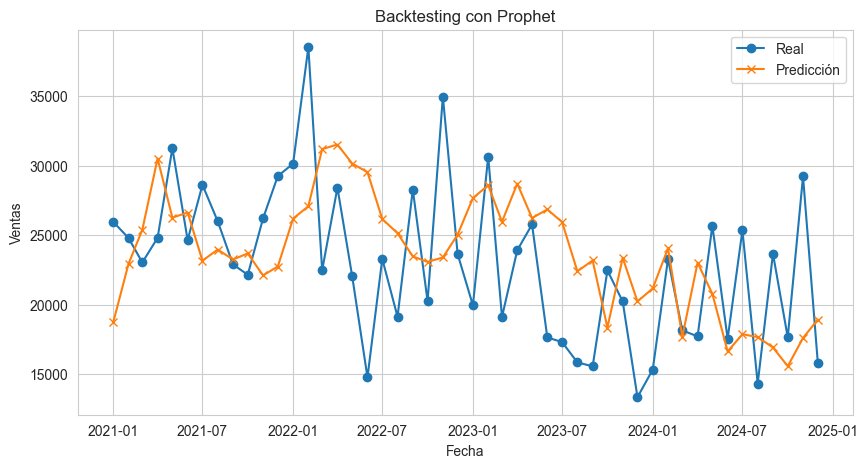

In [17]:
# Graficar resultados
plt.figure(figsize=(10,5))
plt.plot(dates, [df_prophet[df_prophet['ds']==d]['y'].values[0] for d in dates], marker='o', label='Real')
plt.plot(dates, predictions, marker='x', label='Predicción')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Backtesting con Prophet')
plt.legend()
plt.show()

In [18]:
df_prophet = df.copy().reset_index().rename(columns={'Fecha': 'ds', 'SKU_25': 'y'})
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet = df_prophet.sort_values('ds').reset_index(drop=True)

# Parámetros de Backtesting
horizonte = 1         # Pronosticar 1 mes adelante en cada iteración
ventana_min = 36      # Ventana mínima de entrenamiento de 36 meses (3 años)
test_size = len(df_prophet) - ventana_min  # Número de iteraciones de backtesting

prophet_mapes = []
predictions = []
dates = []

best_mape = float('inf')
best_model = None  # Aquí guardaremos el modelo que tenga el menor MAPE
best_iteration = None

for i in range(ventana_min, len(df_prophet)):
    # Entrenamiento con datos desde el inicio hasta el mes i
    train_data = df_prophet.iloc[:i]
    test_data = df_prophet.iloc[i:i+horizonte]  # Pronosticar el siguiente mes
    
    model = Prophet(yearly_seasonality=True,
                    weekly_seasonality=False,
                    daily_seasonality=False, 
                    changepoint_prior_scale=0.1,
                    seasonality_prior_scale=5.0,
                    n_changepoints=20)
    model.fit(train_data)
    
    future = model.make_future_dataframe(periods=horizonte, freq='MS')
    forecast = model.predict(future)
    
    # Extraer la predicción para el primer periodo pronosticado
    y_pred = forecast.iloc[-horizonte]['yhat']
    y_true = test_data.iloc[0]['y']
    
    mape_val = mean_absolute_percentage_error([y_true], [y_pred]) * 100
    prophet_mapes.append(mape_val)
    predictions.append(y_pred)
    dates.append(test_data.iloc[0]['ds'])
    
    print(f"Fecha {test_data.iloc[0]['ds'].date()}: y_true: {y_true:.2f}, y_pred: {y_pred:.2f}, MAPE: {mape_val:.2f}%")
    
    # Si en esta iteración el MAPE es menor al mejor encontrado, guardamos este modelo
    if mape_val < best_mape:
        best_mape = mape_val
        best_model = model  # Guardamos el modelo entrenado en esta iteración
        best_iteration = i

prophet_mape_prom = np.mean(prophet_mapes)
print("\nMAPE promedio Prophet Backtest: {:.2f}%".format(prophet_mape_prom))
print(f"El mejor MAPE fue {best_mape:.2f}% en la iteración {best_iteration}.")

# Guardar el mejor modelo en disco usando pickle
with open("C:/Users/norma/OneDrive/Tecnoquimicas TQ/prueba_tq/models/best_prophet_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

22:50:08 - cmdstanpy - INFO - Chain [1] start processing
22:50:08 - cmdstanpy - INFO - Chain [1] done processing
22:50:08 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-01-01: y_true: 25953.00, y_pred: 18728.85, MAPE: 27.84%


22:50:08 - cmdstanpy - INFO - Chain [1] done processing
22:50:08 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-02-01: y_true: 24792.00, y_pred: 22939.11, MAPE: 7.47%


22:50:08 - cmdstanpy - INFO - Chain [1] done processing
22:50:09 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-03-01: y_true: 23033.00, y_pred: 25385.81, MAPE: 10.21%


22:50:09 - cmdstanpy - INFO - Chain [1] done processing
22:50:09 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-04-01: y_true: 24805.00, y_pred: 30508.47, MAPE: 22.99%


22:50:09 - cmdstanpy - INFO - Chain [1] done processing
22:50:09 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-05-01: y_true: 31255.00, y_pred: 26255.27, MAPE: 16.00%


22:50:09 - cmdstanpy - INFO - Chain [1] done processing
22:50:10 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-06-01: y_true: 24643.00, y_pred: 26625.81, MAPE: 8.05%


22:50:10 - cmdstanpy - INFO - Chain [1] done processing
22:50:10 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-07-01: y_true: 28617.00, y_pred: 23161.29, MAPE: 19.06%


22:50:10 - cmdstanpy - INFO - Chain [1] done processing
22:50:10 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-08-01: y_true: 26001.00, y_pred: 23957.56, MAPE: 7.86%


22:50:10 - cmdstanpy - INFO - Chain [1] done processing
22:50:11 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-09-01: y_true: 22892.00, y_pred: 23250.37, MAPE: 1.57%


22:50:11 - cmdstanpy - INFO - Chain [1] done processing
22:50:11 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-10-01: y_true: 22149.00, y_pred: 23681.68, MAPE: 6.92%


22:50:11 - cmdstanpy - INFO - Chain [1] done processing
22:50:11 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-11-01: y_true: 26197.00, y_pred: 22103.71, MAPE: 15.63%


22:50:11 - cmdstanpy - INFO - Chain [1] done processing
22:50:12 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2021-12-01: y_true: 29249.00, y_pred: 22741.90, MAPE: 22.25%


22:50:12 - cmdstanpy - INFO - Chain [1] done processing
22:50:12 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-01-01: y_true: 30136.00, y_pred: 26188.53, MAPE: 13.10%


22:50:12 - cmdstanpy - INFO - Chain [1] done processing
22:50:12 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-02-01: y_true: 38515.00, y_pred: 27077.57, MAPE: 29.70%


22:50:12 - cmdstanpy - INFO - Chain [1] done processing
22:50:13 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-03-01: y_true: 22471.00, y_pred: 31186.39, MAPE: 38.79%


22:50:13 - cmdstanpy - INFO - Chain [1] done processing
22:50:13 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-04-01: y_true: 28414.00, y_pred: 31515.23, MAPE: 10.91%


22:50:13 - cmdstanpy - INFO - Chain [1] done processing
22:50:13 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-05-01: y_true: 22035.00, y_pred: 30149.41, MAPE: 36.83%


22:50:14 - cmdstanpy - INFO - Chain [1] done processing
22:50:14 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-06-01: y_true: 14769.00, y_pred: 29523.80, MAPE: 99.90%


22:50:14 - cmdstanpy - INFO - Chain [1] done processing
22:50:14 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-07-01: y_true: 23291.28, y_pred: 26163.47, MAPE: 12.33%


22:50:14 - cmdstanpy - INFO - Chain [1] done processing
22:50:14 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-08-01: y_true: 19127.00, y_pred: 25134.36, MAPE: 31.41%


22:50:15 - cmdstanpy - INFO - Chain [1] done processing
22:50:15 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-09-01: y_true: 28276.00, y_pred: 23467.27, MAPE: 17.01%


22:50:15 - cmdstanpy - INFO - Chain [1] done processing
22:50:15 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-10-01: y_true: 20244.00, y_pred: 23072.70, MAPE: 13.97%


22:50:15 - cmdstanpy - INFO - Chain [1] done processing
22:50:15 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-11-01: y_true: 34970.00, y_pred: 23391.34, MAPE: 33.11%


22:50:16 - cmdstanpy - INFO - Chain [1] done processing
22:50:16 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2022-12-01: y_true: 23636.00, y_pred: 25039.81, MAPE: 5.94%


22:50:16 - cmdstanpy - INFO - Chain [1] done processing
22:50:16 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-01-01: y_true: 19950.00, y_pred: 27664.44, MAPE: 38.67%


22:50:16 - cmdstanpy - INFO - Chain [1] done processing
22:50:16 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-02-01: y_true: 30650.00, y_pred: 28588.37, MAPE: 6.73%


22:50:17 - cmdstanpy - INFO - Chain [1] done processing
22:50:17 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-03-01: y_true: 19111.00, y_pred: 25960.37, MAPE: 35.84%


22:50:17 - cmdstanpy - INFO - Chain [1] done processing
22:50:17 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-04-01: y_true: 23912.00, y_pred: 28704.30, MAPE: 20.04%


22:50:17 - cmdstanpy - INFO - Chain [1] done processing
22:50:17 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-05-01: y_true: 25764.00, y_pred: 26230.02, MAPE: 1.81%


22:50:18 - cmdstanpy - INFO - Chain [1] done processing
22:50:18 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-06-01: y_true: 17640.00, y_pred: 26846.74, MAPE: 52.19%


22:50:18 - cmdstanpy - INFO - Chain [1] done processing
22:50:18 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-07-01: y_true: 17306.00, y_pred: 25940.72, MAPE: 49.89%


22:50:18 - cmdstanpy - INFO - Chain [1] done processing
22:50:18 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-08-01: y_true: 15846.00, y_pred: 22400.38, MAPE: 41.36%


22:50:19 - cmdstanpy - INFO - Chain [1] done processing
22:50:19 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-09-01: y_true: 15561.00, y_pred: 23174.77, MAPE: 48.93%


22:50:19 - cmdstanpy - INFO - Chain [1] done processing
22:50:19 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-10-01: y_true: 22460.00, y_pred: 18348.55, MAPE: 18.31%


22:50:20 - cmdstanpy - INFO - Chain [1] done processing
22:50:20 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-11-01: y_true: 20228.00, y_pred: 23372.03, MAPE: 15.54%


22:50:20 - cmdstanpy - INFO - Chain [1] done processing
22:50:20 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2023-12-01: y_true: 13340.00, y_pred: 20228.74, MAPE: 51.64%


22:50:20 - cmdstanpy - INFO - Chain [1] done processing
22:50:20 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-01-01: y_true: 15330.00, y_pred: 21169.24, MAPE: 38.09%


22:50:21 - cmdstanpy - INFO - Chain [1] done processing
22:50:21 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-02-01: y_true: 23291.28, y_pred: 24050.26, MAPE: 3.26%


22:50:21 - cmdstanpy - INFO - Chain [1] done processing
22:50:21 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-03-01: y_true: 18148.00, y_pred: 17689.66, MAPE: 2.53%


22:50:21 - cmdstanpy - INFO - Chain [1] done processing
22:50:22 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-04-01: y_true: 17716.00, y_pred: 23013.47, MAPE: 29.90%


22:50:22 - cmdstanpy - INFO - Chain [1] done processing
22:50:22 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-05-01: y_true: 25681.00, y_pred: 20774.09, MAPE: 19.11%


22:50:22 - cmdstanpy - INFO - Chain [1] done processing
22:50:22 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-06-01: y_true: 17542.00, y_pred: 16633.71, MAPE: 5.18%


22:50:23 - cmdstanpy - INFO - Chain [1] done processing
22:50:23 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-07-01: y_true: 25345.00, y_pred: 17872.63, MAPE: 29.48%


22:50:23 - cmdstanpy - INFO - Chain [1] done processing
22:50:23 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-08-01: y_true: 14324.00, y_pred: 17666.30, MAPE: 23.33%


22:50:23 - cmdstanpy - INFO - Chain [1] done processing
22:50:23 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-09-01: y_true: 23664.00, y_pred: 16917.45, MAPE: 28.51%


22:50:24 - cmdstanpy - INFO - Chain [1] done processing
22:50:24 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-10-01: y_true: 17647.00, y_pred: 15570.49, MAPE: 11.77%


22:50:24 - cmdstanpy - INFO - Chain [1] done processing
22:50:24 - cmdstanpy - INFO - Chain [1] start processing


Fecha 2024-11-01: y_true: 29226.00, y_pred: 17599.45, MAPE: 39.78%


22:50:25 - cmdstanpy - INFO - Chain [1] done processing


Fecha 2024-12-01: y_true: 15834.00, y_pred: 18927.23, MAPE: 19.54%

MAPE promedio Prophet Backtest: 23.76%
El mejor MAPE fue 1.57% en la iteración 44.


### Medias moviles

In [19]:
df_ma = df.copy()
df_ma['MA_3'] = df_ma['SKU_25'].rolling(window=3).mean()

# Vamos a predecir en el período de test usando la MA_3
# la predicción de un mes t es la media de los 3 meses previos.
pred_ma = []
for i in range(len(train), len(df_ma)):
    # i es el índice en df_ma
    # la predicción en i es la media de i-1, i-2, i-3
    window_data = df_ma['SKU_25'].iloc[i-3:i]
    pred_ma.append(window_data.mean())

test_ma = test.copy()
test_ma['MA_pred'] = pred_ma  # alineado con test

ma_mape = mean_absolute_percentage_error(test_ma['SKU_25'], test_ma['MA_pred']) * 100
print("Media Móvil (3) MAPE:", ma_mape)

Media Móvil (3) MAPE: 25.573689249078413


### Evaluación de todos los modelos

In [20]:
model_results = {
    'SARIMAX': sarimax_mape,
    'LSTM': lstm_mape,
    'Prophet': prophet_mape_prom,
    'MovingAverage': ma_mape
}

for model, mape in model_results.items():
    print(f"{model} -> MAPE: {mape:.2f}%")

best_model = min(model_results, key=model_results.get)
best_mape = model_results[best_model]
print(f"\nEl mejor modelo es {best_model} con un MAPE de {best_mape:.2f}%")

# Reducción de error frente a la media móvil
ma_mape_value = model_results['MovingAverage']
error_reduction = ((ma_mape_value - best_mape) / ma_mape_value) * 100
print(f"\nReducción de error vs Media Móvil: {error_reduction:.2f}%")

SARIMAX -> MAPE: 25.15%
LSTM -> MAPE: 28.37%
Prophet -> MAPE: 23.76%
MovingAverage -> MAPE: 25.57%

El mejor modelo es Prophet con un MAPE de 23.76%

Reducción de error vs Media Móvil: 7.11%


### Validación cruzada Backtesting

In [59]:
# TimeSeriesSplit para un backtesting de rolling origin
from sklearn.model_selection import TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
mape_scores = []

In [60]:
def evaluate_model(model_name, y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)*100
    print(f"{model_name} MAPE: {mape:.2f}%")
    return mape

#### Backtesting para SARIMAX

In [61]:
sarimax_mape_list = []

for train_index, test_index in tscv.split(df):
    train_cv = df.iloc[train_index]
    test_cv = df.iloc[test_index]
    
    # Auto ARIMA o elección manual de orden (para simplificar, usamos parámetros fijos)
    order = (1,1,1)
    seasonal_order = (1,1,1,12)
    try:
        model = sm.tsa.statespace.SARIMAX(train_cv['SKU_25'], order=order, seasonal_order=seasonal_order,
                                          enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=len(test_cv))
        forecast = np.atleast_1d(forecast)
        mape_cv = evaluate_model("SARIMAX Backtest", test_cv['SKU_25'], forecast)
        sarimax_mape_list.append(mape_cv)
    except Exception as e:
        #print("Error en SARIMAX:", e)
        pass

print("MAPE promedio SARIMAX Backtest:", np.mean(sarimax_mape_list))

SARIMAX Backtest MAPE: 15.08%
SARIMAX Backtest MAPE: 19.58%
SARIMAX Backtest MAPE: 21.16%
SARIMAX Backtest MAPE: 23.93%
MAPE promedio SARIMAX Backtest: 19.93462858050908


In [ ]:
### Estimación de los siguientes 3 meses con SARIMAX
order = (1,1,1)
seasonal_order = (1,1,1,12)
model = sm.tsa.statespace.SARIMAX(df['SKU_25'], order=order, seasonal_order=seasonal_order,
                                  enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)
forecast = model_fit.forecast(steps=3)
print(f"Pronóstico SARIMAX para los próximos 3 meses: {forecast}")

Pronóstico SARIMAX para los próximos 3 meses: 2025-01-01    19754.518787
2025-02-01    26054.508405
2025-03-01    18008.736427
Freq: MS, Name: predicted_mean, dtype: float64


In [65]:
import pickle

# Guardar el modelo
with open("modelo_sarimax.pkl", "wb") as f:
    pickle.dump(model_fit, f)

# Cargar el modelo
with open("modelo_sarimax.pkl", "rb") as f:
    modelo_cargado = pickle.load(f)

In [66]:
forecast = modelo_cargado.forecast(steps=3)
print(f"Pronóstico SARIMAX para los próximos 3 meses: {forecast}")

Pronóstico SARIMAX para los próximos 3 meses: 2025-01-01    19754.518787
2025-02-01    26054.508405
2025-03-01    18008.736427
Freq: MS, Name: predicted_mean, dtype: float64


#### LSTM con Backtesting Rolling

In [ ]:
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(df[['SKU_25']])

def create_sequences(series, window_size=12):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 12
all_X, all_y = create_sequences(scaled_series, window_size)
n_total = len(all_X)
n_test = 12

lstm_mape_list = []

# Definir la arquitectura del modelo fuera del loop
def build_model(window_size, learning_rate=0.001):
    model = Sequential()
    # Puedes probar con más de una capa LSTM y agregar Dropout
    model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(window_size, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Backtesting rolling
for i in range(n_total - n_test, n_total):
    X_train_lstm = all_X[:i]
    y_train_lstm = all_y[:i]
    X_test_lstm = all_X[i].reshape(1, window_size, 1)
    y_true_lstm = scaler.inverse_transform(all_y[i].reshape(-1, 1))[0, 0]
    
    model_lstm = build_model(window_size, learning_rate=0.001)
    
    # Ajustar EarlyStopping para monitorizar el val_loss (usando una parte del train como validación)
    es = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    model_lstm.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=16, verbose=0, callbacks=[es])
    
    pred_scaled = model_lstm.predict(X_test_lstm)
    pred = scaler.inverse_transform(pred_scaled)[0, 0]
    mape_val = mean_absolute_percentage_error([y_true_lstm], [pred]) * 100
    lstm_mape_list.append(mape_val)
    print(f"LSTM backtesting iteración {i}: MAPE {mape_val:.2f}%")
print("MAPE promedio LSTM Backtest:", np.mean(lstm_mape_list))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
LSTM backtesting iteración 60: MAPE 34.85%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
LSTM backtesting iteración 61: MAPE 12.12%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
LSTM backtesting iteración 62: MAPE 11.27%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
LSTM backtesting iteración 63: MAPE 13.96%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
LSTM backtesting iteración 64: MAPE 22.84%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
LSTM backtesting iteración 65: MAPE 15.96%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
LSTM backtesting iteración 66: MAPE 24.87%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
LSTM backtesting iteración 67: MAPE 41.51%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
LSTM backtesting iteración 68: MAPE 14.05%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
LSTM backtesting iteración 69: MAPE 16.90%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
LSTM backtesting iteración 70: MAPE 29.97%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
LSTM backtesting iteración 71: MAPE 36.86%
MAPE promedio LS

In [25]:
scaler = MinMaxScaler()
scaled_series = scaler.fit_transform(df[['SKU_25']])

def create_sequences(series, window_size=12):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)

window_size = 12  # Se aumenta la ventana para dar mayor contexto
all_X, all_y = create_sequences(scaled_series, window_size)

# Dividir en conjunto de entrenamiento y validación (ejemplo 80% entrenamiento, 20% validación)
split = int(0.8 * len(all_X))
X_train, y_train = all_X[:split], all_y[:split]
X_val, y_val = all_X[split:], all_y[split:]
X_train = X_train.reshape(-1, window_size, 1)
X_val = X_val.reshape(-1, window_size, 1)

In [26]:
def objective(params):
    # Construir el modelo LSTM con los hiperparámetros actuales
    model = Sequential()
    model.add(LSTM(units=int(params['units_1']),
                   activation='tanh',
                   return_sequences=True,
                   input_shape=(window_size, 1)))
    model.add(Dropout(rate=params['dropout_1']))
    
    model.add(LSTM(units=int(params['units_2']),
                   activation='tanh'))
    model.add(Dropout(rate=params['dropout_2']))
    
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')
    
    # EarlyStopping para evitar sobreajuste
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  restore_best_weights=True)
    
    # Entrenamiento del modelo
    history = model.fit(X_train, y_train,
                        epochs=50,
                        batch_size=16,
                        validation_data=(X_val, y_val),
                        verbose=0,
                        callbacks=[early_stop])
    
    # La métrica a minimizar es la pérdida mínima en el conjunto de validación
    val_loss = np.min(history.history['val_loss'])
    print(f"Parametros: {params} --> val_loss: {val_loss:.6f}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

# Definir el espacio de búsqueda
space = {
    'units_1': hp.quniform('units_1', 32, 128, 32),   # Ejemplo: 32, 64, 96, 128
    'dropout_1': hp.uniform('dropout_1', 0.1, 0.5),
    'units_2': hp.quniform('units_2', 16, 64, 16),     # Ejemplo: 16, 32, 48, 64
    'dropout_2': hp.uniform('dropout_2', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2))
}

In [27]:
trials = Trials()

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,  # Puedes incrementar este valor para explorar más combinaciones
            trials=trials)

print("Mejores hiperparámetros encontrados:")
print(best)

Parametros: {'dropout_1': 0.4745251175295164, 'dropout_2': 0.20878271481039934, 'learning_rate': 0.0002761848351417652, 'units_1': 64.0, 'units_2': 16.0} --> val_loss: 0.035388
Parametros: {'dropout_1': 0.29553448340287597, 'dropout_2': 0.13649636039177368, 'learning_rate': 0.0012923568957479254, 'units_1': 96.0, 'units_2': 48.0} --> val_loss: 0.034793
Parametros: {'dropout_1': 0.17153975431963747, 'dropout_2': 0.3586266691813289, 'learning_rate': 0.0033705127037621423, 'units_1': 32.0, 'units_2': 48.0} --> val_loss: 0.034322
Parametros: {'dropout_1': 0.14829723959837865, 'dropout_2': 0.12920126305158053, 'learning_rate': 0.0022812398561491954, 'units_1': 128.0, 'units_2': 32.0} --> val_loss: 0.034289
Parametros: {'dropout_1': 0.2694238111350956, 'dropout_2': 0.4012386841802795, 'learning_rate': 0.000130372391120706, 'units_1': 96.0, 'units_2': 64.0} --> val_loss: 0.035152
Parametros: {'dropout_1': 0.16810113126359263, 'dropout_2': 0.285013038558936, 'learning_rate': 0.0046504279421422

In [28]:
# Modelo con los mejores hiperparámetros
best_model = Sequential()
best_model.add(LSTM(units=int(best['units_1']),
                    activation='tanh',
                    return_sequences=True,
                    input_shape=(window_size, 1)))
best_model.add(Dropout(rate=best['dropout_1']))
best_model.add(LSTM(units=int(best['units_2']),
                    activation='tanh'))
best_model.add(Dropout(rate=best['dropout_2']))
best_model.add(Dense(1))

optimizer = Adam(learning_rate=best['learning_rate'])
best_model.compile(optimizer=optimizer, loss='mse')

# Entrenamos con EarlyStopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              restore_best_weights=True)
history = best_model.fit(X_train, y_train,
                         epochs=50,
                         batch_size=16,
                         validation_data=(X_val, y_val),
                         verbose=1,
                         callbacks=[early_stop])

val_loss = best_model.evaluate(X_val, y_val)
print("Validation loss del mejor modelo:", val_loss)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 225ms/step - loss: 0.1378 - val_loss: 0.0412
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0585 - val_loss: 0.0345
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0486 - val_loss: 0.0365
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0383 - val_loss: 0.0384
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0471 - val_loss: 0.0403
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0411 - val_loss: 0.0346
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0440 - val_loss: 0.0400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0345
Validation loss del mejor modelo: 0.03446542099118233


In [38]:
# predicciones en el conjunto de validación
preds = best_model.predict(X_val)

# Desescalar las predicciones y los valores reales
preds_inversed = scaler.inverse_transform(preds)
y_val_inversed = scaler.inverse_transform(y_val)

# Calcular el MAPE
mape_LSTM = mean_absolute_percentage_error(y_val_inversed, preds_inversed) * 100
print("El MAPE para el mejor modelo es: {:.2f}%".format(mape_LSTM))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
El MAPE para el mejor modelo es: 22.07%


#### Prophet (Backtesting sencillo)

In [ ]:
df_prophet = df.reset_index().rename(columns={'Fecha': 'ds', 'SKU_25': 'y'})
train_prophet = df_prophet.iloc[:-test_size]
test_prophet = df_prophet.iloc[-test_size:]

model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(train_prophet)
future = model_prophet.make_future_dataframe(periods=test_size, freq='MS')
forecast = model_prophet.predict(future)
forecast_test = forecast.iloc[-test_size:][['ds','yhat']]

prophet_mape = mean_absolute_percentage_error(test_prophet['y'], forecast_test['yhat'])*100
print("Prophet MAPE Backtest:", prophet_mape)

22:56:45 - cmdstanpy - INFO - Chain [1] start processing
22:56:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet MAPE Backtest: 25.077376089115088


In [31]:
space = {
    'changepoint_prior_scale': hp.loguniform('changepoint_prior_scale', np.log(0.05), np.log(0.2)),
    'seasonality_prior_scale': hp.loguniform('seasonality_prior_scale', np.log(3), np.log(7)),
    'n_changepoints': hp.quniform('n_changepoints', 15, 25, 1)
}

In [34]:
from prophet.diagnostics import cross_validation, performance_metrics

df_prophet2 = df.copy().reset_index().rename(columns={'Fecha': 'ds', 'SKU_25': 'y'})
df_prophet2['ds'] = pd.to_datetime(df_prophet2['ds'])
df_prophet2 = df_prophet2.sort_values('ds').reset_index(drop=True)

space = {
    'changepoint_prior_scale': hp.loguniform('changepoint_prior_scale', np.log(0.05), np.log(0.2)),
    'seasonality_prior_scale': hp.loguniform('seasonality_prior_scale', np.log(3), np.log(7)),
    'n_changepoints': hp.quniform('n_changepoints', 15, 25, 1)
}

def objective(params):
    # Convertir n_changepoints a entero
    params['n_changepoints'] = int(params['n_changepoints'])
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        n_changepoints=params['n_changepoints']
    )
    model.fit(df_prophet2)
    
    df_cv = cross_validation(
        model,
        initial='1095 days',  # 3 years
        horizon='365 days',   # 1 year
        period='365 days'     # 1 year
    )
    df_metrics = performance_metrics(df_cv)
    mape = df_metrics['mape'].mean()
    print(f"Params: {params} -> MAPE: {mape:.4f}")
    return {'loss': mape, 'status': STATUS_OK}

trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20,  # Aumenta este valor para explorar más combinaciones
    trials=trials
)

print("Mejores hiperparámetros encontrados:")
print(best)

  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

22:58:40 - cmdstanpy - INFO - Chain [1] start processing
22:58:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:58:40 - cmdstanpy - INFO - Chain [1] start processing
22:58:41 - cmdstanpy - INFO - Chain [1] done processing
22:58:41 - cmdstanpy - INFO - Chain [1] start processing
22:58:41 - cmdstanpy - INFO - Chain [1] done processing
22:58:41 - cmdstanpy - INFO - Chain [1] start processing
22:58:41 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.05792602376369614, 'n_changepoints': 19, 'seasonality_prior_scale': 4.376847501270584} -> MAPE: 0.2939
  5%|▌         | 1/20 [00:01<00:32,  1.73s/trial, best loss: 0.2939080217641623]

22:58:42 - cmdstanpy - INFO - Chain [1] start processing
22:58:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:58:42 - cmdstanpy - INFO - Chain [1] start processing
22:58:42 - cmdstanpy - INFO - Chain [1] done processing
22:58:42 - cmdstanpy - INFO - Chain [1] start processing
22:58:43 - cmdstanpy - INFO - Chain [1] done processing
22:58:43 - cmdstanpy - INFO - Chain [1] start processing
22:58:43 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.1367900015460336, 'n_changepoints': 16, 'seasonality_prior_scale': 6.011052924571503} -> MAPE: 0.2967
 10%|█         | 2/20 [00:03<00:29,  1.66s/trial, best loss: 0.2939080217641623]

22:58:43 - cmdstanpy - INFO - Chain [1] start processing
22:58:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:58:44 - cmdstanpy - INFO - Chain [1] start processing
22:58:44 - cmdstanpy - INFO - Chain [1] done processing
22:58:44 - cmdstanpy - INFO - Chain [1] start processing
22:58:44 - cmdstanpy - INFO - Chain [1] done processing
22:58:44 - cmdstanpy - INFO - Chain [1] start processing
22:58:45 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.07983624148953015, 'n_changepoints': 23, 'seasonality_prior_scale': 5.350909552987998} -> MAPE: 0.2907
 15%|█▌        | 3/20 [00:04<00:27,  1.64s/trial, best loss: 0.29074860232105554]

22:58:45 - cmdstanpy - INFO - Chain [1] start processing
22:58:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:58:45 - cmdstanpy - INFO - Chain [1] start processing
22:58:46 - cmdstanpy - INFO - Chain [1] done processing
22:58:46 - cmdstanpy - INFO - Chain [1] start processing
22:58:46 - cmdstanpy - INFO - Chain [1] done processing
22:58:46 - cmdstanpy - INFO - Chain [1] start processing
22:58:46 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.15842674820557764, 'n_changepoints': 25, 'seasonality_prior_scale': 4.857307115071444} -> MAPE: 0.3002
 20%|██        | 4/20 [00:06<00:27,  1.69s/trial, best loss: 0.29074860232105554]

22:58:47 - cmdstanpy - INFO - Chain [1] start processing
22:58:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:58:47 - cmdstanpy - INFO - Chain [1] start processing
22:58:47 - cmdstanpy - INFO - Chain [1] done processing
22:58:47 - cmdstanpy - INFO - Chain [1] start processing
22:58:48 - cmdstanpy - INFO - Chain [1] done processing
22:58:48 - cmdstanpy - INFO - Chain [1] start processing
22:58:48 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.07011268502028944, 'n_changepoints': 24, 'seasonality_prior_scale': 4.570406955034322} -> MAPE: 0.2893
 25%|██▌       | 5/20 [00:08<00:24,  1.64s/trial, best loss: 0.2892944290633786] 

22:58:48 - cmdstanpy - INFO - Chain [1] start processing
22:58:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:58:49 - cmdstanpy - INFO - Chain [1] start processing
22:58:49 - cmdstanpy - INFO - Chain [1] done processing
22:58:49 - cmdstanpy - INFO - Chain [1] start processing
22:58:49 - cmdstanpy - INFO - Chain [1] done processing
22:58:49 - cmdstanpy - INFO - Chain [1] start processing
22:58:50 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.07686816082296433, 'n_changepoints': 23, 'seasonality_prior_scale': 4.5395502085102954} -> MAPE: 0.2907
 30%|███       | 6/20 [00:09<00:22,  1.62s/trial, best loss: 0.2892944290633786]

22:58:50 - cmdstanpy - INFO - Chain [1] start processing
22:58:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:58:50 - cmdstanpy - INFO - Chain [1] start processing
22:58:50 - cmdstanpy - INFO - Chain [1] done processing
22:58:50 - cmdstanpy - INFO - Chain [1] start processing
22:58:51 - cmdstanpy - INFO - Chain [1] done processing
22:58:51 - cmdstanpy - INFO - Chain [1] start processing
22:58:51 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.05151175412985792, 'n_changepoints': 22, 'seasonality_prior_scale': 6.341347261336461} -> MAPE: 0.3031
 35%|███▌      | 7/20 [00:11<00:20,  1.56s/trial, best loss: 0.2892944290633786]

22:58:51 - cmdstanpy - INFO - Chain [1] start processing
22:58:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:58:52 - cmdstanpy - INFO - Chain [1] start processing
22:58:52 - cmdstanpy - INFO - Chain [1] done processing
22:58:52 - cmdstanpy - INFO - Chain [1] start processing
22:58:52 - cmdstanpy - INFO - Chain [1] done processing
22:58:52 - cmdstanpy - INFO - Chain [1] start processing
22:58:52 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.12452694413514365, 'n_changepoints': 18, 'seasonality_prior_scale': 6.260534378064642} -> MAPE: 0.2957
 40%|████      | 8/20 [00:12<00:18,  1.54s/trial, best loss: 0.2892944290633786]

22:58:53 - cmdstanpy - INFO - Chain [1] start processing
22:58:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:58:53 - cmdstanpy - INFO - Chain [1] start processing
22:58:53 - cmdstanpy - INFO - Chain [1] done processing
22:58:53 - cmdstanpy - INFO - Chain [1] start processing
22:58:54 - cmdstanpy - INFO - Chain [1] done processing
22:58:54 - cmdstanpy - INFO - Chain [1] start processing
22:58:54 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.12809362126593335, 'n_changepoints': 17, 'seasonality_prior_scale': 4.456900096508412} -> MAPE: 0.2966
 45%|████▌     | 9/20 [00:14<00:16,  1.53s/trial, best loss: 0.2892944290633786]

22:58:54 - cmdstanpy - INFO - Chain [1] start processing
22:58:54 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:58:55 - cmdstanpy - INFO - Chain [1] start processing
22:58:55 - cmdstanpy - INFO - Chain [1] done processing
22:58:55 - cmdstanpy - INFO - Chain [1] start processing
22:58:55 - cmdstanpy - INFO - Chain [1] done processing
22:58:55 - cmdstanpy - INFO - Chain [1] start processing
22:58:55 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.08185045089124889, 'n_changepoints': 18, 'seasonality_prior_scale': 3.8521027821383065} -> MAPE: 0.2908
 50%|█████     | 10/20 [00:15<00:14,  1.48s/trial, best loss: 0.2892944290633786]

22:58:56 - cmdstanpy - INFO - Chain [1] start processing
22:58:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:58:56 - cmdstanpy - INFO - Chain [1] start processing
22:58:56 - cmdstanpy - INFO - Chain [1] done processing
22:58:56 - cmdstanpy - INFO - Chain [1] start processing
22:58:56 - cmdstanpy - INFO - Chain [1] done processing
22:58:57 - cmdstanpy - INFO - Chain [1] start processing
22:58:57 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.18046789214024123, 'n_changepoints': 15, 'seasonality_prior_scale': 3.8185994675785837} -> MAPE: 0.3061
 55%|█████▌    | 11/20 [00:17<00:13,  1.49s/trial, best loss: 0.2892944290633786]

22:58:57 - cmdstanpy - INFO - Chain [1] start processing
22:58:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:58:57 - cmdstanpy - INFO - Chain [1] start processing
22:58:58 - cmdstanpy - INFO - Chain [1] done processing
22:58:58 - cmdstanpy - INFO - Chain [1] start processing
22:58:58 - cmdstanpy - INFO - Chain [1] done processing
22:58:58 - cmdstanpy - INFO - Chain [1] start processing
22:58:58 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.07390933764218101, 'n_changepoints': 19, 'seasonality_prior_scale': 5.771460592961686} -> MAPE: 0.2878
 60%|██████    | 12/20 [00:18<00:11,  1.47s/trial, best loss: 0.28778619514075393]

22:58:58 - cmdstanpy - INFO - Chain [1] start processing
22:58:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:58:59 - cmdstanpy - INFO - Chain [1] start processing
22:58:59 - cmdstanpy - INFO - Chain [1] done processing
22:58:59 - cmdstanpy - INFO - Chain [1] start processing
22:58:59 - cmdstanpy - INFO - Chain [1] done processing
22:59:00 - cmdstanpy - INFO - Chain [1] start processing
22:59:00 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.06548468291132453, 'n_changepoints': 23, 'seasonality_prior_scale': 3.7490177102728497} -> MAPE: 0.2900
 65%|██████▌   | 13/20 [00:20<00:10,  1.50s/trial, best loss: 0.28778619514075393]

22:59:00 - cmdstanpy - INFO - Chain [1] start processing
22:59:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:59:00 - cmdstanpy - INFO - Chain [1] start processing
22:59:01 - cmdstanpy - INFO - Chain [1] done processing
22:59:01 - cmdstanpy - INFO - Chain [1] start processing
22:59:01 - cmdstanpy - INFO - Chain [1] done processing
22:59:01 - cmdstanpy - INFO - Chain [1] start processing
22:59:01 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.15086525053281155, 'n_changepoints': 16, 'seasonality_prior_scale': 3.547281726889962} -> MAPE: 0.2999
 70%|███████   | 14/20 [00:21<00:08,  1.48s/trial, best loss: 0.28778619514075393]

22:59:01 - cmdstanpy - INFO - Chain [1] start processing
22:59:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:59:02 - cmdstanpy - INFO - Chain [1] start processing
22:59:02 - cmdstanpy - INFO - Chain [1] done processing
22:59:02 - cmdstanpy - INFO - Chain [1] start processing
22:59:03 - cmdstanpy - INFO - Chain [1] done processing
22:59:03 - cmdstanpy - INFO - Chain [1] start processing
22:59:03 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.07841282528333267, 'n_changepoints': 24, 'seasonality_prior_scale': 3.6616494460850166} -> MAPE: 0.2899
 75%|███████▌  | 15/20 [00:23<00:07,  1.51s/trial, best loss: 0.28778619514075393]

22:59:03 - cmdstanpy - INFO - Chain [1] start processing
22:59:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:59:03 - cmdstanpy - INFO - Chain [1] start processing
22:59:04 - cmdstanpy - INFO - Chain [1] done processing
22:59:04 - cmdstanpy - INFO - Chain [1] start processing
22:59:04 - cmdstanpy - INFO - Chain [1] done processing
22:59:04 - cmdstanpy - INFO - Chain [1] start processing
22:59:04 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.05464994349776094, 'n_changepoints': 17, 'seasonality_prior_scale': 4.512639773318037} -> MAPE: 0.3039
 80%|████████  | 16/20 [00:24<00:05,  1.44s/trial, best loss: 0.28778619514075393]

22:59:04 - cmdstanpy - INFO - Chain [1] start processing
22:59:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:59:05 - cmdstanpy - INFO - Chain [1] start processing
22:59:05 - cmdstanpy - INFO - Chain [1] done processing
22:59:05 - cmdstanpy - INFO - Chain [1] start processing
22:59:06 - cmdstanpy - INFO - Chain [1] done processing
22:59:06 - cmdstanpy - INFO - Chain [1] start processing
22:59:06 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.18743042062736343, 'n_changepoints': 22, 'seasonality_prior_scale': 4.311099469840054} -> MAPE: 0.3042
 85%|████████▌ | 17/20 [00:26<00:04,  1.58s/trial, best loss: 0.28778619514075393]

22:59:06 - cmdstanpy - INFO - Chain [1] start processing
22:59:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:59:07 - cmdstanpy - INFO - Chain [1] start processing
22:59:07 - cmdstanpy - INFO - Chain [1] done processing
22:59:07 - cmdstanpy - INFO - Chain [1] start processing
22:59:07 - cmdstanpy - INFO - Chain [1] done processing
22:59:07 - cmdstanpy - INFO - Chain [1] start processing
22:59:07 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.15021969166482613, 'n_changepoints': 16, 'seasonality_prior_scale': 4.280497372467992} -> MAPE: 0.3009
 90%|█████████ | 18/20 [00:27<00:03,  1.52s/trial, best loss: 0.28778619514075393]

22:59:08 - cmdstanpy - INFO - Chain [1] start processing
22:59:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:59:08 - cmdstanpy - INFO - Chain [1] start processing
22:59:08 - cmdstanpy - INFO - Chain [1] done processing
22:59:09 - cmdstanpy - INFO - Chain [1] start processing
22:59:09 - cmdstanpy - INFO - Chain [1] done processing
22:59:09 - cmdstanpy - INFO - Chain [1] start processing
22:59:09 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.11867583159781869, 'n_changepoints': 15, 'seasonality_prior_scale': 3.905075354721219} -> MAPE: 0.2948
 95%|█████████▌| 19/20 [00:29<00:01,  1.53s/trial, best loss: 0.28778619514075393]

22:59:09 - cmdstanpy - INFO - Chain [1] start processing
22:59:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

22:59:10 - cmdstanpy - INFO - Chain [1] start processing
22:59:10 - cmdstanpy - INFO - Chain [1] done processing
22:59:10 - cmdstanpy - INFO - Chain [1] start processing
22:59:10 - cmdstanpy - INFO - Chain [1] done processing
22:59:10 - cmdstanpy - INFO - Chain [1] start processing
22:59:10 - cmdstanpy - INFO - Chain [1] done processing


Params: {'changepoint_prior_scale': 0.0696679118999375, 'n_changepoints': 24, 'seasonality_prior_scale': 4.232385053116571} -> MAPE: 0.2886
100%|██████████| 20/20 [00:30<00:00,  1.54s/trial, best loss: 0.28778619514075393]
Mejores hiperparámetros encontrados:
{'changepoint_prior_scale': 0.07390933764218101, 'n_changepoints': 19.0, 'seasonality_prior_scale': 5.771460592961686}


#### Modelo de Media Móvil (Benchmark)

In [45]:
df_ma = df.copy()
df_ma['MA_3'] = df_ma['SKU_25'].rolling(window=3).mean()

pred_ma = []
for i in range(len(train), len(df_ma)):
    window_data = df_ma['SKU_25'].iloc[i-3:i]
    pred_ma.append(window_data.mean())

test_ma = test.copy()
test_ma['MA_pred'] = pred_ma

ma_mape = mean_absolute_percentage_error(test_ma['SKU_25'], test_ma['MA_pred']) * 100
print("Media Móvil (3) MAPE:", ma_mape)

Media Móvil (3) MAPE: 25.573689249078413


### Evaluación de modelos

In [ ]:
# Para SARIMAX:
mape_sarimax =  np.mean(sarimax_mape_list)
print("SARIMAX MAPE: {:.2f}%".format(mape_sarimax))

# Para LSTM:
mape_lstm = mean_absolute_percentage_error(y_val_inversed, preds_inversed) * 100
print("LSTM MAPE: {:.2f}%".format(mape_lstm))
mape_LSTM_Backtest = np.mean(lstm_mape_list)
print("LSTM MAPE Backtest: {:.2f}%".format(mape_LSTM_Backtest))

# Para Prophet:
#mape_prophet = (test_prophet['y'], forecast_test['yhat'])*100
#print("Prophet MAPE: {:.2f}%".format(mape_prophet))
prophet_mape1 = mean_absolute_percentage_error(test_prophet['y'], forecast_test['yhat'])*100
print("Prophet MAPE: {:.2f}%".format(prophet_mape1))

# Para Media Móvil:
mape_ma = ma_mape
print("Media Móvil MAPE: {:.2f}%".format(mape_ma))


SARIMAX MAPE: 19.93%
LSTM MAPE: 22.07%
LSTM MAPE: 22.93%
Prophet MAPE: 25.08%
Media Móvil MAPE: 25.57%


In [50]:
resultados_modelos = {
    'SARIMAX': np.mean(sarimax_mape_list),
    'LSTM': mean_absolute_percentage_error(y_val_inversed, preds_inversed) * 100,
    'Prophet': prophet_mape1,
    'MediaMóvil': ma_mape
}

print("\nComparación de Modelos (MAPE):")
for modelo, mape in resultados_modelos.items():
    print(f"{modelo}: {mape:.2f}%")

# Se escoge el mejor (mínimo MAPE) y se calcula la reducción de error vs la media móvil.
mejor_modelo = min(resultados_modelos, key=lambda k: resultados_modelos[k] if not np.isnan(resultados_modelos[k]) else np.inf)
mejor_mape = resultados_modelos[mejor_modelo]
reduccion_error = ((ma_mape - mejor_mape) / ma_mape) * 100
print(f"\nEl mejor modelo es {mejor_modelo} con MAPE {mejor_mape:.2f}%.")
print(f"Reducción de error vs Media Móvil: {reduccion_error:.2f}%")


Comparación de Modelos (MAPE):
SARIMAX: 19.93%
LSTM: 22.07%
Prophet: 25.08%
MediaMóvil: 25.57%

El mejor modelo es SARIMAX con MAPE 19.93%.
Reducción de error vs Media Móvil: 22.05%


In [51]:
best_model_name = mejor_modelo
best_mape = mejor_mape

print(f"El mejor modelo es {best_model_name} con un MAPE de {best_mape:.2f}%.")

# Guarda el modelo en disco usando pickle (para modelos de statsmodels o Keras, se puede usar pickle o joblib)
with open("C:/Users/norma/OneDrive/Tecnoquimicas TQ/prueba_tq/modelsbest_model.pkl", "wb") as file:
    pickle.dump(model_results[best_model_name], file)

print("El mejor modelo se ha guardado en 'best_model.pkl'.")


El mejor modelo es SARIMAX con un MAPE de 19.93%.
El mejor modelo se ha guardado en 'best_model.pkl'.


In [ ]:
########################################### FIN ###########################################